# Week 12: Colab Experiment

# I. Introduction
In this exercise, we learn an autoencoder to reconstruct the MNIST images and extract the representations.

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random


In [5]:
# Run this once to load the train and test data straight into a dataloader class
# that will provide the batches
batch_size_train = 64
batch_size_test = 1000
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

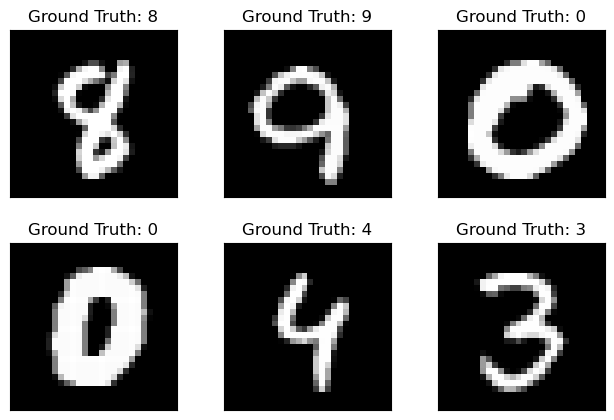

In [7]:
# Let's draw some of the training data
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

# II. Methods

In [111]:
# TODO : Finish the Model
input_dim = example_data[0].numel()  # Dimensions in one example
class LAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            # TODO
            # The encoder at least 3 hidden layers, each with 128, 64, and 2 hidden units respectively
            nn.Linear(in_features=input_dim, out_features=128), 
            nn.ELU(), # I found out using Exponential Linear Unit (ELU) result with good performan
            nn.Linear(128, 64),
            nn.ELU(),
            nn.Linear(64, 2)
            )
        self.decoder = nn.Sequential(
            # TODO
            # The decoder also has at least 3 layers with the same number of hidden units in reversed order
            nn.Linear(2, 64),
            nn.ELU(),
            nn.Linear(64, 128),
            nn.ELU(),
            nn.Linear(128, input_dim),
            )

    def forward(self, x):
        # TODO
        x = x.view(x.size(0), -1)
        latent = self.encoder(x)
        x = self.decoder(latent)

        return x,latent

# Training steps

In [113]:
num_epochs = 10
learning_rate = 2e-3


model = LAutoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(
    model.parameters(), lr=learning_rate)

# TODO : Finish the training steps
# Training loop
for epoch in range(num_epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.view(data.size(0), -1)  # Flatten to [batch_size, input_dim]
        
        optimizer.zero_grad()  # Zero the gradients

        # Forward pass: data is passed through the model to get predictions
        reconstructed, _ = model(data)  # We only care about the reconstruction

        # Compute the loss: MSE loss between the input and the reconstructed output
        loss = criterion(reconstructed, data)  # Compare input and output

        # Backward pass: compute gradients
        loss.backward()

        # Update the model's parameters
        optimizer.step()
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.data.item()}')


epoch [1/10], loss:0.42544907331466675
epoch [2/10], loss:0.44475263357162476
epoch [3/10], loss:0.38498812913894653
epoch [4/10], loss:0.3951890766620636
epoch [5/10], loss:0.38768935203552246
epoch [6/10], loss:0.4128611385822296
epoch [7/10], loss:0.3310031592845917
epoch [8/10], loss:0.3787629008293152
epoch [9/10], loss:0.44336482882499695
epoch [10/10], loss:0.38922107219696045


## III. Results

We train the autoencoder model and apply it to the test set. There is no validation set here, we simply take the model at the end of the training procedure. The scatter plot of the embeddings are shown below, with each digit colored differently.

In [115]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


def scatter_plot(data_loader):

  d = {0: 'red', 1: "green", 2: "blue", 3: "maroon", 4: "yellow",
      5: "pink", 6: "brown", 7: "black", 8: "teal", 9: "aqua"}

  colors = []
  latent_variables = []
  labels = []

  for data in test_loader:
    img, label = data
    img = img.view(img.size(0), -1)
    model.cpu()
    _,latent = model(img)
    latent_variables.append(latent)
    labels.append(label)


  latent_variables = torch.cat(latent_variables, dim=0)
  labels = torch.cat(labels, dim=0)


  df = pd.DataFrame(data = latent_variables.detach().numpy(), columns = ['Latent feature 1', 'Latent feature 2'])
  df['label'] = labels.numpy()

  fig = plt.figure(dpi=200)
  sns.scatterplot(data=df, x="Latent feature 1", y="Latent feature 2", hue="label", palette="deep")
  plt.show()

The test set:


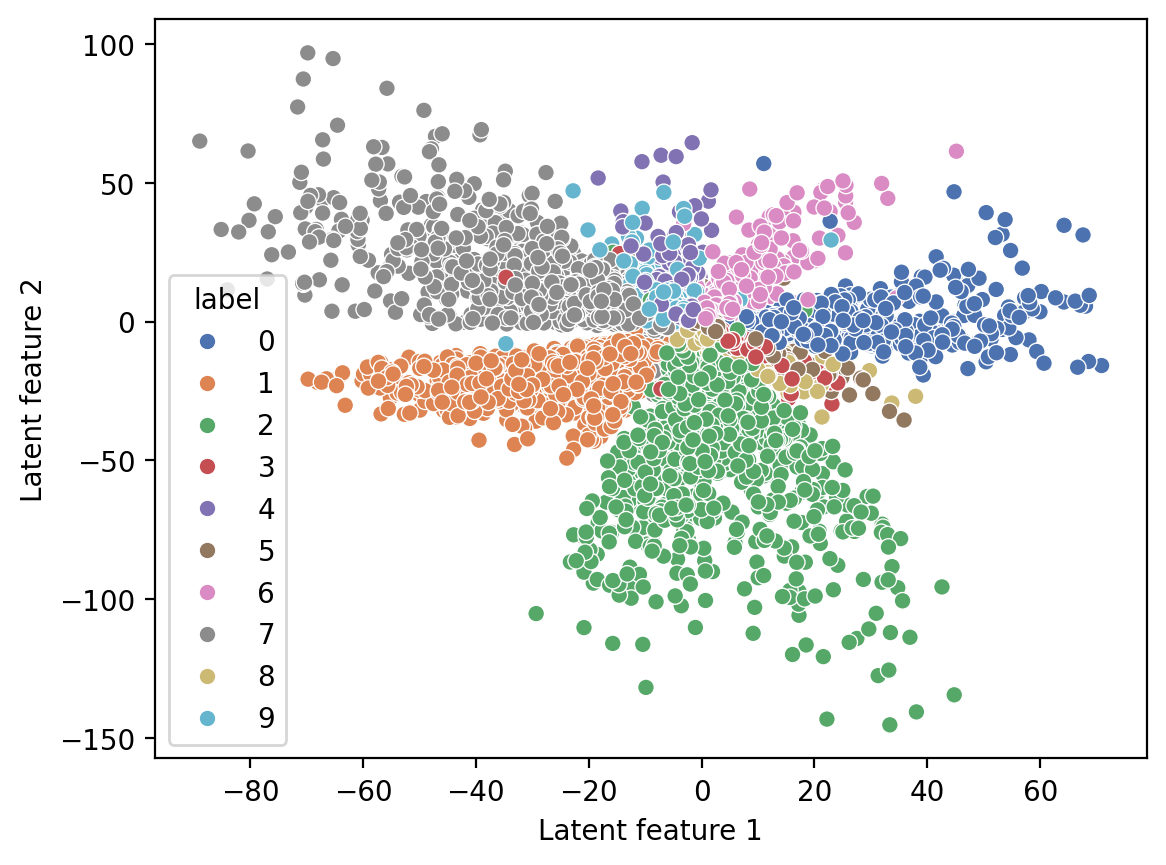

In [117]:
print("The test set:")
scatter_plot(test_loader)

# IV. Conclusion and Discussion



In this project, I constructed and trained an autoencoder to compress and reconstruct image data, specifically handwritten digits from the MNIST dataset. The autoencoder consisted of an encoder with three hidden layers, where the input image was compressed into a 2-dimensional latent space, and a decoder aimed to reconstruct the input. After experimenting with different activation functions, I settled on using the Exponential Linear Unit (ELU), which proved effective for training stability and performance. Flattening the input images and adjusting the architecture ensured that the model could successfully map the high-dimensional image data into a compact latent space.

The model successfully learned to encode the handwritten digits into a 2-dimensional latent space, allowing for a clear separation between the digits 1 through 10. This indicates that the autoencoder compressed the data and preserved meaningful features, allowing for distinct clustering of the different digit classes. The use of ELU activation contributed to smooth training and effective representation learning, while the model's latent space demonstrated its ability to capture the underlying structure of the handwritten digits. This result opens the door for further exploration into generative tasks, such as using the latent space for digit generation or transfer learning.